In [419]:
import numpy as np 
import pandas as pd
import simpy
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns 
import graphviz 
import cairosvg

np.random.seed(40)

In [437]:
def bipartite_layout(inputG, LR=True):
    ## bipartite한 graph의 layout
    if nx.is_bipartite(inputG) and nx.is_connected(inputG):## connected and bipartite
        bs1, bs2 = nx.bipartite.sets(inputG)
        bs1 = sorted(bs1, key=lambda x: x, reverse=True)
        bs2 = sorted(bs2, key=lambda x: x, reverse=True)
        pos = {}
        if LR==True:
            pos.update({n:(0, 1.0/(len(bs1)+1)*(i+1)) for i, n in enumerate(bs1)})
            pos.update({n:(1, 1.0/(len(bs2)+1)*(i+1)) for i, n in enumerate(bs2)})
        else:
            pos.update({n:(1.0 - 1.0/(len(bs1)+1)*(i+1), 1) for i, n in enumerate(bs1)})
            pos.update({n:(1.0 - 1.0/(len(bs2)+1)*(i+1), 0) for i, n in enumerate(bs2)})
        return pos
    else:# 이 경우 none을 리턴하므로, default layout으로 그림이 그려지게 됩니다. 
        print("it is not bipartite and not connected")

def make_deg_seq(deg_sum, seq_a_len, max_deg):
    ## deg_sum에 맞도록 degree dist를 랜덤하게 분포함
    ## max_deg는 한 node가 가질 수 있는 최대 degree, 여기서는 multi graph가 아닌 graph로 가정 
    ## partition을 이용해서 만드는 방법도 해봤지만, 속도 문제가 너무 큼, 당연한것이 아래는 단 하나의 조건만을 만드는 경우, 
    ## partition을 이용하면, 모든 종류를 다 만드는 경우 
    if deg_sum > (seq_a_len*max_deg):
        print("deg_sum is too large")
    elif deg_sum < seq_a_len or deg_sum < max_deg:
        print("deg_sum is too small")
    else: 
        seq_a = [1 for i in range(0, seq_a_len)]
        remain_seq_a = deg_sum - seq_a_len
        while remain_seq_a>0:
            idx = np.random.choice(seq_a_len)
            if seq_a[idx]+1<=max_deg:
                seq_a[idx]+=1
                remain_seq_a-=1
        return seq_a

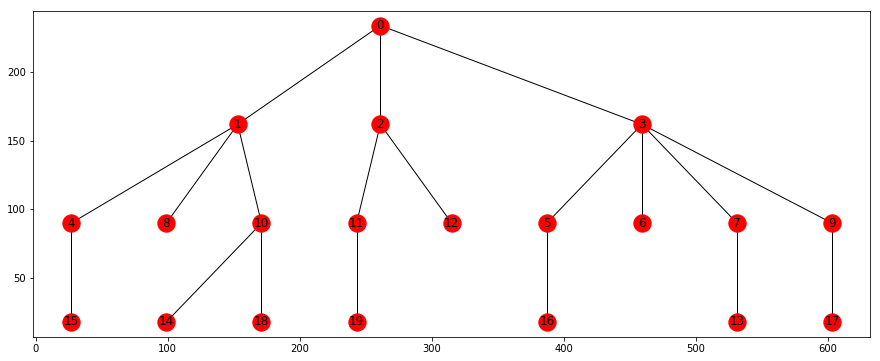

In [438]:
def make_balanced_random_tree(node_size, branching, height):
    ## 최대 branching의 수, height를 정하고, node_size만큼의 tree를 만듭니다. 
    bg = nx.balanced_tree(branching, height-1)
    if len(bg.nodes()) < node_size:
        print("len(bg.nodes()) < node_size")
    bg.remove_nodes_from(list(bg.nodes())[node_size:])# 정해진 node의 수를 넘는 노드는 다 삭제 
    level_node = [[0], ]## 레벨별로 들어가야 하는 노드를 리스트로 넣어둠 
    for i in range(0, height-1):
        left, right = sum([branching**j for j in range(0, i+1)]), sum([branching**(j+1) for j in range(0, i+1)])
        level_node.append([k for k in range(left, right+1)])
    ## make it random: 임의로 선을 바꿈 
    for i in range(1, len(level_node)-1):
        for j in range(0, 100):
            edges = [e for e in bg.edges() if e[0] in level_node[i] and e[1] in level_node[i+1]]
            r_e = edges[np.random.randint(0, len(edges))]
            bg.remove_edge(r_e[0], r_e[1]), bg.add_edge(np.random.choice(level_node[i]), r_e[1])
    return bg

bg = make_balanced_random_tree(20, 3, 4)
pos=nx.drawing.nx_agraph.graphviz_layout(bg, prog='dot')
plt.figure(figsize=(15, 6))
nx.draw_networkx(bg, pos)
plt.show()

In [439]:
## draw process 
def activity_lst_to_png(activity_lst, output_file_name):
    def save_graph_as_svg(dot_string, output_file_name):
        if type(dot_string) is str:## dot language string으로 들어올 때, 
            g = graphviz.Source(dot_string)
        elif isinstance(dot_string, (graphviz.dot.Digraph, graphviz.dot.Graph)):## 객체로 들어올 때 
            g = dot_string
        else:
            print("can't handle it"), 
            return None
        ### outputfile 
        g.filename, g.format = output_file_name.split('.')[0], 'svg'
        g.directory = '../../assets/images/markdown_img/'
        g.render(view=False)
        ## svg to png, requried import cairosvg
        if output_file_name.split('.')[1]=='png':
            cairosvg.svg2png(url=g.directory+g.filename+"."+'svg',
                             write_to=g.directory+output_file_name, dpi = 200)
        return g
    activity_lst = ["Source"]+activity_lst+['Sink']
    BP = graphviz.Digraph(comment='business process')
    BP.graph_attr['rankdir'] = 'LR'
    ## add node 
    for i, act in enumerate(activity_lst):
        if act in ['Source', 'Sink']: ## 처음이거나 끝일 때는 노드를 다르게 표시 
            BP.node(act, shape="doublecircle", color='red') if act=='Source' else BP.node(act, shape="doublecircle", color='blue')
        else:
            BP.node(act, shape='rectangle')
    ## add edge 
    for i in range(0, len(activity_lst)-1):
        BP.edge(activity_lst[i], activity_lst[i+1])
    save_graph_as_svg(BP, output_file_name)
    return BP

In [440]:
## resource와 activity를 bipartite한 네트워크로 구성하고, 
## activity를 수행해야 할 때는 일단 해당 activity를 수행할 수 있는 사람셋을 해당 네트워크를 통해서 찾음 
## 액티비티 종료 후 
#act_resource_network = nx.Graph()
class Activity(object):
    def __init__(self, name, t_dist=(1,3,5)):
        self.name = name
        self.t_dist = t_dist# (min, max, mode)
    def __repr__(self):
        return self.name
    
class Resource(object):
    def __init__(self, name, t_dist=(1,3,5)):
        self.name = name
        self.t_dist = t_dist
    def __repr__(self):
        return self.name


##### setting
## 여기서 각 A_set와 R_set를 만들어 준다. 
A_set = [Activity('A{:0>2d}'.format(i), (1, 3, 5)) for i in range(0, 5)]
R_set = [Resource('R{:0>2d}'.format(i), (1, 2, 1.5)) for i in range(0, 20)]
#########################
deg_sum = len(R_set)*len(A_set)*0.4//1.0
R_A_net = nx.bipartite.havel_hakimi_graph(make_deg_seq(deg_sum, len(R_set), len(A_set)), 
                                          make_deg_seq(deg_sum, len(A_set), len(R_set))
                                         )

## update type attribute
mapping = {}
for i, n in enumerate([n[0] for n in R_A_net.nodes(data=True) if n[1]['bipartite']==0]):
    R_A_net.nodes[n]['type']='Resource' ## for relabeling 
    R_A_net.nodes[n]['Resource']=R_set[i]
    mapping[n] = R_set[i].name
for i, n in enumerate([n[0] for n in R_A_net.nodes(data=True) if n[1]['bipartite']==1]):
    R_A_net.nodes[n]['type']='Activity'
    R_A_net.nodes[n]['Activity']=A_set[i]
    mapping[n] = A_set[i].name
R_A_net = nx.relabel_nodes(R_A_net, mapping)
## make R_net 
R_net = make_balanced_random_tree(len(R_set), 3, 4)
for n, r in zip(R_net.nodes(), np.random.choice(R_set, len(R_set), replace=False)):
    R_net.nodes[n]['Resource'] = r
R_net = nx.relabel_nodes(R_net, mapping = {n[0]:n[1]['Resource'].name for n in R_net.nodes(data=True)})

[('R04', {'Resource': R04}), ('R17', {'Resource': R17}), ('R14', {'Resource': R14}), ('R13', {'Resource': R13}), ('R11', {'Resource': R11}), ('R16', {'Resource': R16}), ('R07', {'Resource': R07}), ('R01', {'Resource': R01}), ('R09', {'Resource': R09}), ('R15', {'Resource': R15}), ('R05', {'Resource': R05}), ('R03', {'Resource': R03}), ('R12', {'Resource': R12}), ('R00', {'Resource': R00}), ('R19', {'Resource': R19}), ('R18', {'Resource': R18}), ('R10', {'Resource': R10}), ('R02', {'Resource': R02}), ('R06', {'Resource': R06}), ('R08', {'Resource': R08})]


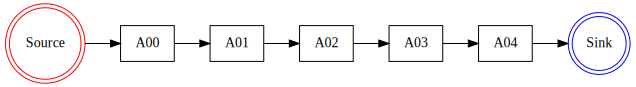

In [442]:
activity_lst_to_png([a.name for a in A_set], 'sequential_bp.png')

[4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1]
----------------------------------------
[11, 8, 8, 7, 6]
----------------------------------------


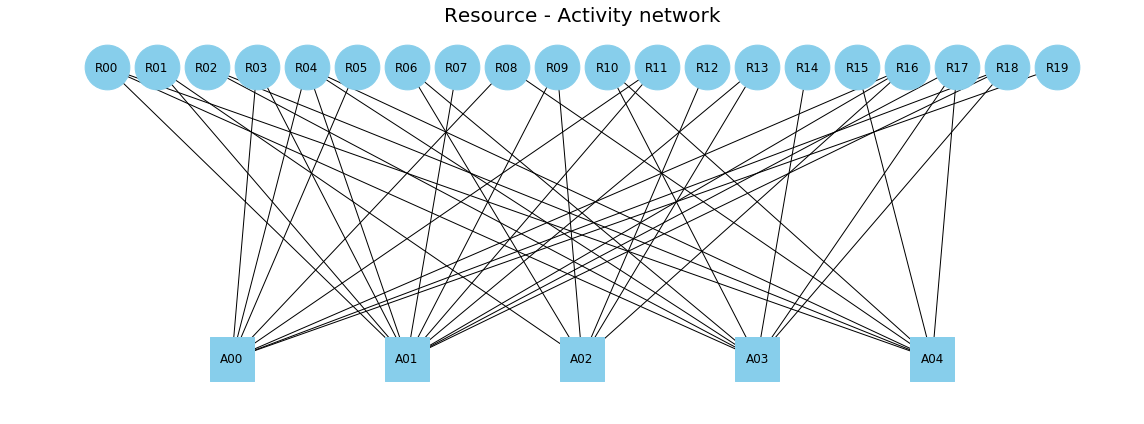

In [443]:
for s in nx.bipartite.sets(R_A_net):
    degs = sorted([x[1] for x in R_A_net.degree(s)], reverse=True)
    print(degs), print("-"*40)

plt.figure(figsize=(16, 6))
pos = bipartite_layout(R_A_net, LR=False)
nx.draw_networkx(R_A_net, pos=pos, node_size=200, node_color='skyblue')
nx.draw_networkx_nodes(R_A_net, pos=pos, nodelist=nx.bipartite.sets(R_A_net)[0], node_shape='o',
                       node_size=2000, node_color='skyblue')
nx.draw_networkx_nodes(R_A_net, pos=pos, nodelist=nx.bipartite.sets(R_A_net)[1], node_shape='s',
                       node_size=2000, node_color='skyblue')

#nx.draw_networkx(R_net, pos=tree_position(R_net), node_size=2000, node_color='skyblue', ax = axes[1])
plt.axis('off')
plt.title('Resource - Activity network', fontsize=20)
#axes[1].set_title('Resource Network', fontsize=20)
## degree dist check
plt.tight_layout()
plt.savefig('../../assets/images/markdown_img/180816_RA_net.png', dpi=200)
plt.show()

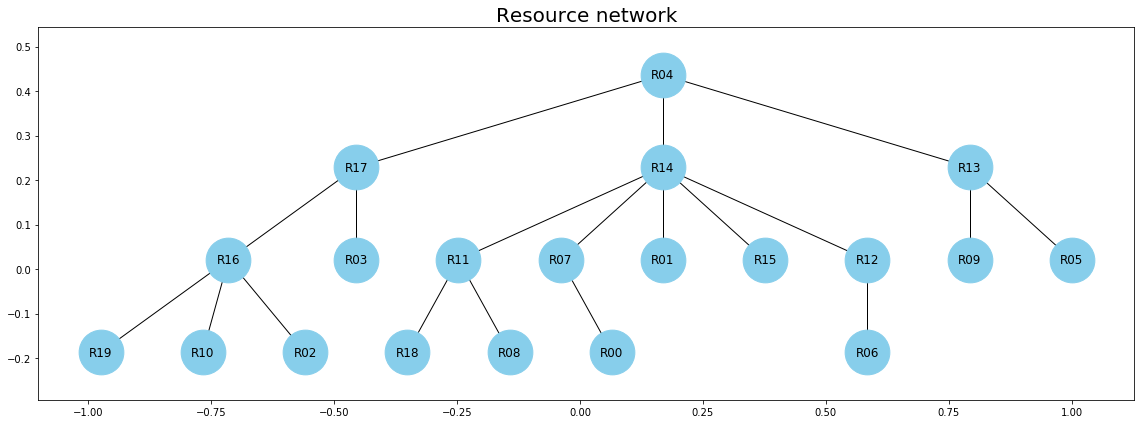

In [470]:
pos=nx.drawing.nx_agraph.graphviz_layout(R_net, prog='dot')
new_pos = nx.drawing.layout.rescale_layout(np.array([[v[0], v[1]] for v in pos.values()]), 1)
new_pos = {k:v for k, v in zip(pos.keys(), new_pos)}
plt.figure(figsize=(16, 6))
nx.draw_networkx(R_net, pos=new_pos, node_size=2000, node_color='skyblue')
#plt.axis('off')
plt.title('Resource network', fontsize=20)
#axes[1].set_title('Resource Network', fontsize=20)
plt.tight_layout()
plt.show()

In [475]:
pos = nx.drawing.nx_agraph.graphviz_layout(R_net, prog='dot')
for k, v in pos.items():
    print("{}: {}".format(k, v))

R04: (423.0, 234.0)
R17: (207.0, 162.0)
R14: (423.0, 162.0)
R13: (639.0, 162.0)
R11: (279.0, 90.0)
R16: (117.0, 90.0)
R07: (351.0, 90.0)
R01: (423.0, 90.0)
R09: (639.0, 90.0)
R15: (495.0, 90.0)
R05: (711.0, 90.0)
R03: (207.0, 90.0)
R12: (567.0, 90.0)
R00: (387.0, 18.0)
R19: (27.0, 18.0)
R18: (243.0, 18.0)
R10: (99.0, 18.0)
R02: (171.0, 18.0)
R06: (567.0, 18.0)
R08: (315.0, 18.0)


In [477]:
pos = nx.drawing.nx_agraph.graphviz_layout(R_net, prog='dot')
new_pos = nx.drawing.layout.rescale_layout(np.array([[v[0], v[1]] for v in pos.values()]), 1)
new_pos = {k:tuple(v) for k, v in zip(pos.keys(), new_pos)}
for k, v in new_pos.items():
    print("{}: {}".format(k, v))
    nx.sp

In [482]:
def rescale_layout(pos, scale=1):
    pos_v = np.array([[v[0], v[1]] for v in pos.values()])
    lim = 0  # max coordinate for all axes
    for i in range(pos_v.shape[1]):
        pos_v[:, i] -= pos_v[:, i].mean()
        lim = max(abs(pos_v[:, i]).max(), lim)
    # rescale to (-scale, scale) in all directions, preserves aspect
    if lim > 0:
        for i in range(pos_v.shape[1]):
            pos_v[:, i] *= scale / lim
    return {k: tuple(v) for k, v in zip(pos.keys(), pos_v)}
rescale_layout(pos)

{'R04': (0.16883116883116883, 0.43636363636363634),
 'R17': (-0.45454545454545453, 0.22857142857142859),
 'R14': (0.16883116883116883, 0.22857142857142859),
 'R13': (0.79220779220779225, 0.22857142857142859),
 'R11': (-0.24675324675324675, 0.020779220779220786),
 'R16': (-0.7142857142857143, 0.020779220779220786),
 'R07': (-0.03896103896103896, 0.020779220779220786),
 'R01': (0.16883116883116883, 0.020779220779220786),
 'R09': (0.79220779220779225, 0.020779220779220786),
 'R15': (0.37662337662337664, 0.020779220779220786),
 'R05': (1.0, 0.020779220779220786),
 'R03': (-0.45454545454545453, 0.020779220779220786),
 'R12': (0.58441558441558439, 0.020779220779220786),
 'R00': (0.064935064935064929, -0.18701298701298699),
 'R19': (-0.97402597402597402, -0.18701298701298699),
 'R18': (-0.35064935064935066, -0.18701298701298699),
 'R10': (-0.76623376623376627, -0.18701298701298699),
 'R02': (-0.55844155844155841, -0.18701298701298699),
 'R06': (0.58441558441558439, -0.18701298701298699),
 'R0

R04: (0.16883116883116883, 0.43636363636363634)
R17: (-0.45454545454545453, 0.22857142857142859)
R14: (0.16883116883116883, 0.22857142857142859)
R13: (0.79220779220779225, 0.22857142857142859)
R11: (-0.24675324675324675, 0.020779220779220786)
R16: (-0.7142857142857143, 0.020779220779220786)
R07: (-0.03896103896103896, 0.020779220779220786)
R01: (0.16883116883116883, 0.020779220779220786)
R09: (0.79220779220779225, 0.020779220779220786)
R15: (0.37662337662337664, 0.020779220779220786)
R05: (1.0, 0.020779220779220786)
R03: (-0.45454545454545453, 0.020779220779220786)
R12: (0.58441558441558439, 0.020779220779220786)
R00: (0.064935064935064929, -0.18701298701298699)
R19: (-0.97402597402597402, -0.18701298701298699)
R18: (-0.35064935064935066, -0.18701298701298699)
R10: (-0.76623376623376627, -0.18701298701298699)
R02: (-0.55844155844155841, -0.18701298701298699)
R06: (0.58441558441558439, -0.18701298701298699)
R08: (-0.14285714285714285, -0.18701298701298699)


In [471]:
nx.sp

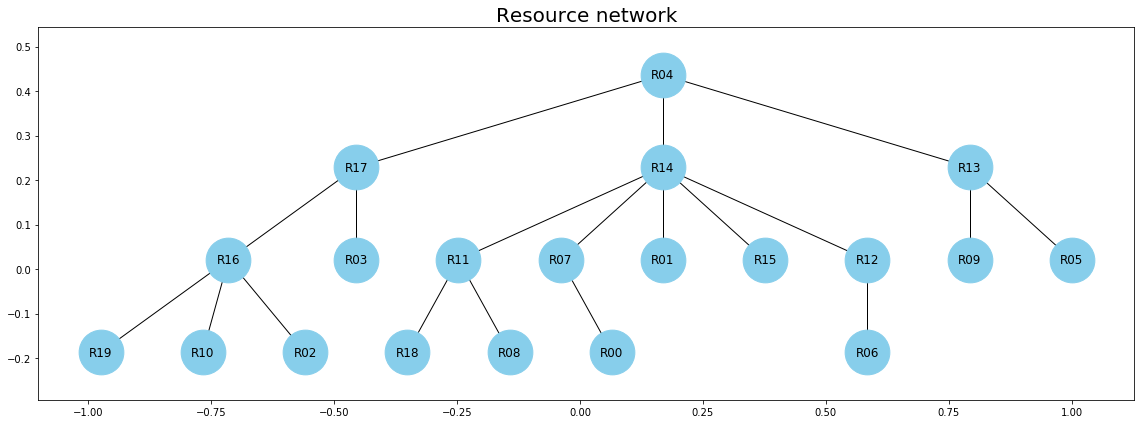

In [471]:
plt.figure(figsize=(16, 6))
pos=nx.drawing.nx_agraph.graphviz_layout(R_net, prog='dot')
new_pos = nx.drawing.layout.rescale_layout(np.array([[v[0], v[1]] for v in pos.values()]), 1)
new_pos = {k:v for k, v in zip(pos.keys(), new_pos)}

nx.draw_networkx(R_net, pos=new_pos, node_size=2000, node_color='skyblue')
#plt.axis('off')
plt.title('Resource network', fontsize=20)
#axes[1].set_title('Resource Network', fontsize=20)
plt.tight_layout()
plt.show()


[(R19, R05), (R05, R15), (R15, R18), (R18, R02), (R02, R08), (R08, R17)]


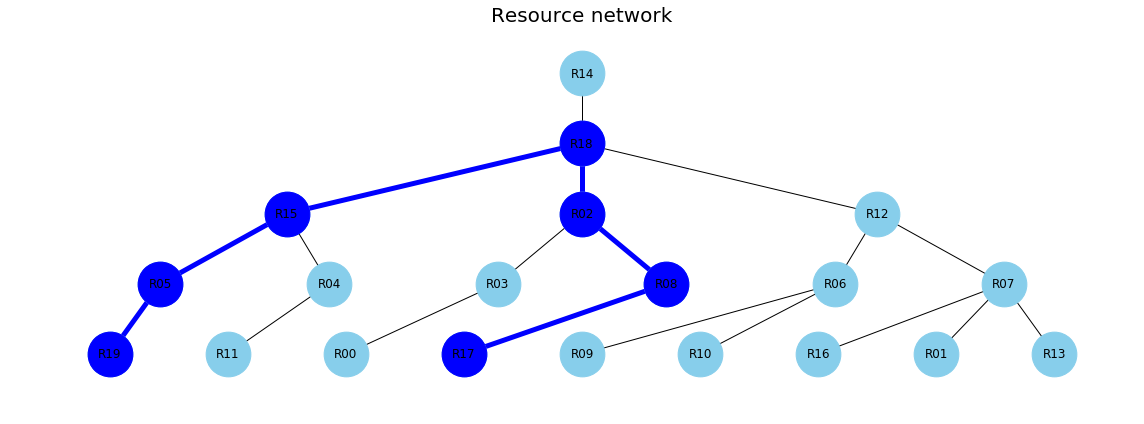

In [418]:
plt.figure(figsize=(16, 6))
nx.draw_networkx(R_net, pos=tree_position(R_net), node_size=2000, node_color='skyblue')
print()
s_p = nx.shortest_path(R_net, [n for n in R_net.nodes() if n.name=='R19'][0], [n for n in R_net.nodes() if n.name=='R17'][0])
edges = [(s_p[i], s_p[i+1]) for i in range(0, len(s_p)-1)]
nx.draw_networkx_edges(R_net, pos=tree_position(R_net), edgelist=edges, width=5, 
                       edge_color='blue')
nx.draw_networkx_nodes(R_net, pos=tree_position(R_net), 
                       nodelist=nx.shortest_path(R_net, [n for n in R_net.nodes() if n.name=='R19'][0], [n for n in R_net.nodes() if n.name=='R17'][0]),
                       node_color='blue', node_size=2000,
                      )
print(edges)
plt.axis('off')
plt.title('Resource network', fontsize=20)
#axes[1].set_title('Resource Network', fontsize=20)
plt.tight_layout()
plt.savefig('../../assets/images/markdown_img/180816_R_net_with_sp.png', dpi=200)
plt.show()

In [313]:
log_df = [] ## log 
def process(env, process_name, activity_lst, human_store):
    ## print('<{}> start                at {:8.2f}'.format(process_name, env.now))
    ## process의 activity를 수행할 리소스 조합을 찾음
    resource_lst = [np.random.choice(list(R_A_net.neighbors(act))) for act in activity_lst]
    for i, act_r in enumerate(zip(activity_lst, resource_lst)):
        act, r = act_r
        left, mode, right = act.t_dist 
        human = yield human_store.get(lambda x: True if x is r else False )
        ## (process_name, activity_name, resource, start or end, timestamp)
        log_df.append( (process_name, act.name, human.name, 'start', env.now) )
        ## print("<{}> {} start by {}     at {:6.2f}".format(process_name, act.name, human, env.now))
        execution_time = np.random.triangular(left=left, right=right, mode=mode)
        yield env.timeout(execution_time)
        yield human_store.put(human)
        ## print("<{}> {}   end by {}     at {:6.2f}".format(process_name, act.name, human, env.now))
        log_df.append( (process_name, act.name, human.name, 'end', env.now) )
        ## 여기서는 transfer of work이 있으므로 일을 조직구조에 따라서 일을 전달함. 
        if (i+1) < len(resource_lst) and r != resource_lst[i+1]:## 마지막 activity가 아닐 때만 다음 resource를 찾아줌 
                resource_path = nx.shortest_path(R_net, r, resource_lst[i+1])
                ## print("<{}> transfer start:      at {:6.2f}".format(process_name, env.now))
                for i in range(0, len(resource_path[1:-1])):
                    ## edge time 
                    ## print("<{}> transfer {} => {}  at {:6.2f}".format(process_name, resource_path[i], resource_path[i+1], env.now))
                    yield env.timeout(np.random.triangular(1, 2, 3)) 
                    ## print('<{}> {} execute transfer at {:6.2f}'.format(process_name, resource_path[i+1], env.now))
                    ## node time
                    tranfer_h = yield human_store.get(lambda x: True if x is r else False )
                    yield env.timeout(np.random.triangular(1, 2, 3)) ## node time 
                    yield human_store.put(tranfer_h)
                ## edge time
                ## print("<{}> transfer {} => {}  at {:6.2f}".format(process_name, resource_path[-2], resource_path[-1], env.now))
                yield env.timeout(np.random.triangular(1, 2, 3))
                #print("transfer {} => {}".format())
                ## print("<{}> transfer end         at {:6.2f}".format(process_name, env.now))
    ## print('<{}> end                  at {:8.2f}'.format(process_name, env.now))
    return None

def process_generator(env, activity_set, resource_set, process_size):
    ## 주기적으로 process 를 env에 등록함 
    human_store = simpy.FilterStore(env)
    human_store.items = [r for r in resource_set]
    for i in range(0, process_size):
        yield env.timeout(np.random.triangular(1, 3, 5))
        ## 만약 activity-set에 약간 랜덤성을 부여하고 싶을 경우, 여기서 activity-set를 알아서 조절해서 넘김 
        ## 예를 들어서, exclusive하게 process 의 activity 조합이 만들어진 경우에는 활률적으로 activity를 조절하여 넘김 
        env.process(
            process(env=env, 
                    process_name = 'Process{:0>2d}'.format(i), 
                    activity_lst = activity_set, human_store = human_store)
        )
        
###########
env = simpy.Environment()

env.process(process_generator(env, A_set, R_set, process_size=500))
env.run()
print('complete')

complete


In [314]:
"""
- heatmap을 그려줌 
- resource간의 transfer할때 발생하는 bottleneck를 표현해줌
"""
df = pd.DataFrame(log_df, columns = ['process', 'activity', 'resource', 'start_end', 'timestamp'])

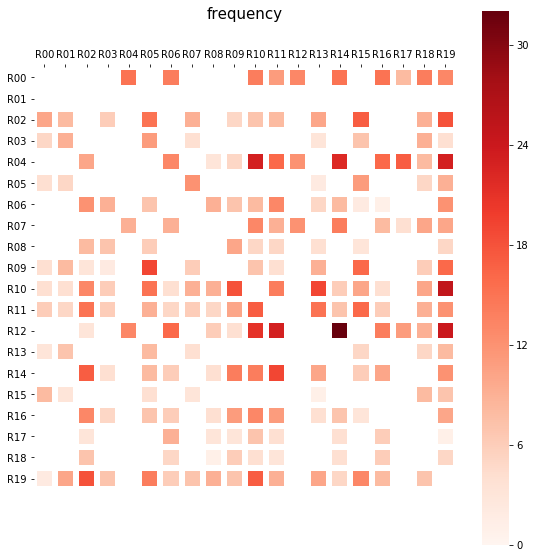

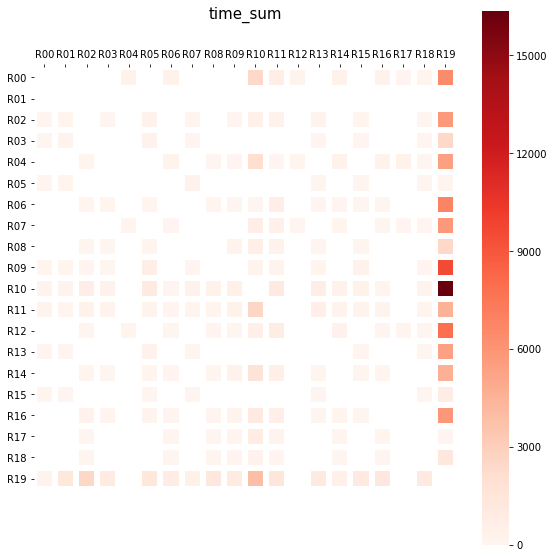

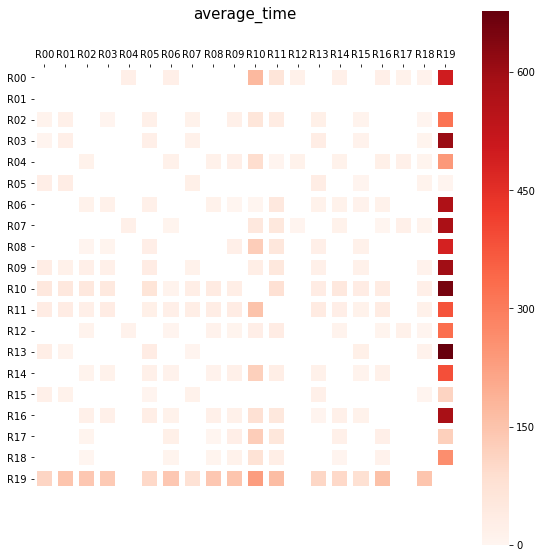

In [315]:
r_columns = sorted(set(df['resource']))

R_R_matrix = {
    'frequency': pd.DataFrame(np.zeros((len(r_columns), len(r_columns))), columns = r_columns, index=r_columns), 
    'time_sum': pd.DataFrame(np.zeros((len(r_columns), len(r_columns))), columns = r_columns, index=r_columns)
}

for g in df.groupby('process'):
    sub_df = g[1].iloc()[1:-1]
    for i in range(0, len(sub_df), 2):
        from_series, to_series = sub_df.iloc()[i], sub_df.iloc()[i+1]
        if from_series.resource != to_series.resource:## 같을 때는 transfer of work이 아님.       
            R_R_matrix['frequency'][from_series.resource][to_series.resource] += 1
            R_R_matrix['time_sum'][from_series.resource][to_series.resource] += (to_series['timestamp'] - from_series['timestamp'])
R_R_matrix['average_time'] = (R_R_matrix['time_sum']/ R_R_matrix['frequency']).fillna(0)
## frequency heatmap 
for k in R_R_matrix.keys():
    plt.figure(figsize=(8, 8))
    sns.heatmap(R_R_matrix[k], cmap=plt.cm.Reds, 
                mask = R_R_matrix[k].applymap(lambda x: False if x!=0 else True), 
                linewidths=5, cbar=True, square=True)
    plt.tick_params(labelsize=10)
    #title_pos = sum(plt.xlim())/2, plt.ylim()[0]
    plt.title(k, position=(0.5, 1+0.1), fontsize=15)## title 위치 변경 
    plt.gca().xaxis.tick_top(), plt.xticks(rotation=0), plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

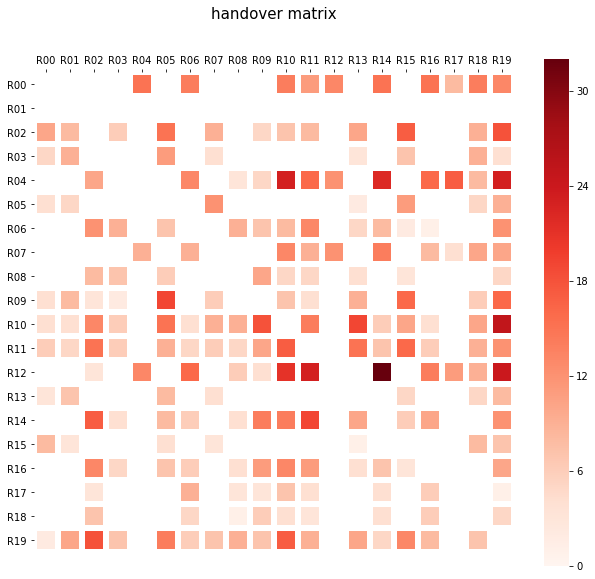

In [352]:
## handover matrix 
plt.figure(figsize=(9, 8))
sns.heatmap(R_R_matrix['frequency'], cmap=plt.cm.Reds, 
            mask = R_R_matrix[k].applymap(lambda x: False if x!=0 else True), 
            linewidths=5, cbar=True, square=True)
plt.tick_params(labelsize=10)
plt.title('handover matrix', position=(0.5, 1+0.1), fontsize=15)## title 위치 변경 
plt.gca().xaxis.tick_top(), plt.xticks(rotation=0), plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../../assets/images/markdown_img/180816_handover_matrix.png', dpi=200)
plt.show()

In [343]:
OC_matrix = R_R_matrix['frequency'].copy()
for col in OC_matrix:
    for idx in OC_matrix.index:
        t_r = [n for n in R_net.nodes() if n.name==col][0]
        f_r = [n for n in R_net.nodes() if n.name==idx][0]
        if nx.shortest_path_length(R_net, f_r, t_r)!=1:
            OC_matrix[t_r.name][f_r.name]=0

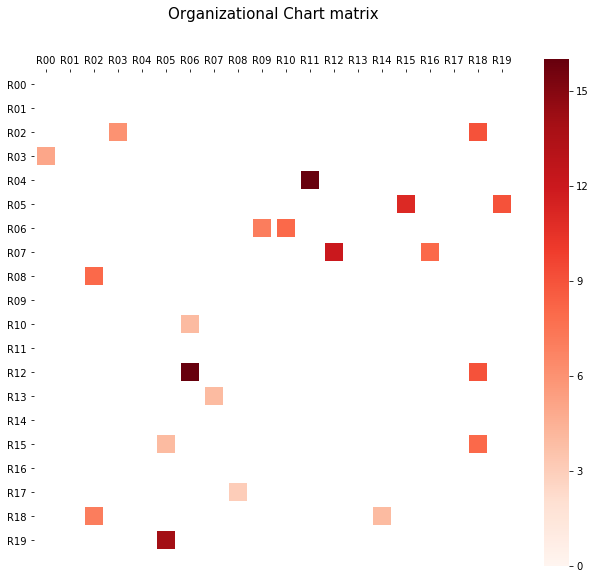

In [354]:
plt.figure(figsize=(9, 8))
sns.heatmap(OC_matrix, cmap=plt.cm.Reds, 
            mask = OC_matrix.applymap(lambda x: False if x!=0 else True), 
            linewidths=5, cbar=True, square=True)
plt.tick_params(labelsize=10)
plt.title('Organizational Chart matrix', position=(0.5, 1+0.1), fontsize=15)## title 위치 변경 
plt.gca().xaxis.tick_top(), plt.xticks(rotation=0), plt.yticks(rotation=0)
plt.tight_layout(), 
plt.savefig('../../assets/images/markdown_img/180816_oc_matrix.png', dpi=200)
plt.show()

In [372]:
tempG = R_net.copy()
aa = [n for n in tempG.nodes() if n.name=='R19'][0]
tempG.remove_edges_from([e for e in tempG.edges(data=True) if aa in e])
tempG.add_edge([n for n in tempG.nodes() if n.name=='R19'][0], [n for n in tempG.nodes() if n.name=='R12'][0])

In [378]:
pos

{R14: (0.5, 0.8333333333333334),
 R18: (0.5, 0.6666666666666667),
 R15: (0.25, 0.5),
 R02: (0.5, 0.5),
 R12: (0.75, 0.5),
 R05: (0.14285714285714285, 0.33333333333333337),
 R04: (0.2857142857142857, 0.33333333333333337),
 R03: (0.42857142857142855, 0.33333333333333337),
 R08: (0.5714285714285714, 0.33333333333333337),
 R06: (0.7142857142857142, 0.33333333333333337),
 R07: (0.8571428571428571, 0.33333333333333337),
 R19: (1, 0.2),
 R11: (0.2, 0.16666666666666674),
 R00: (0.30000000000000004, 0.16666666666666674),
 R17: (0.4, 0.16666666666666674),
 R09: (0.5, 0.16666666666666674),
 R10: (0.6000000000000001, 0.16666666666666674),
 R16: (0.7000000000000001, 0.16666666666666674),
 R01: (0.8, 0.16666666666666674),
 R13: (0.9, 0.16666666666666674)}

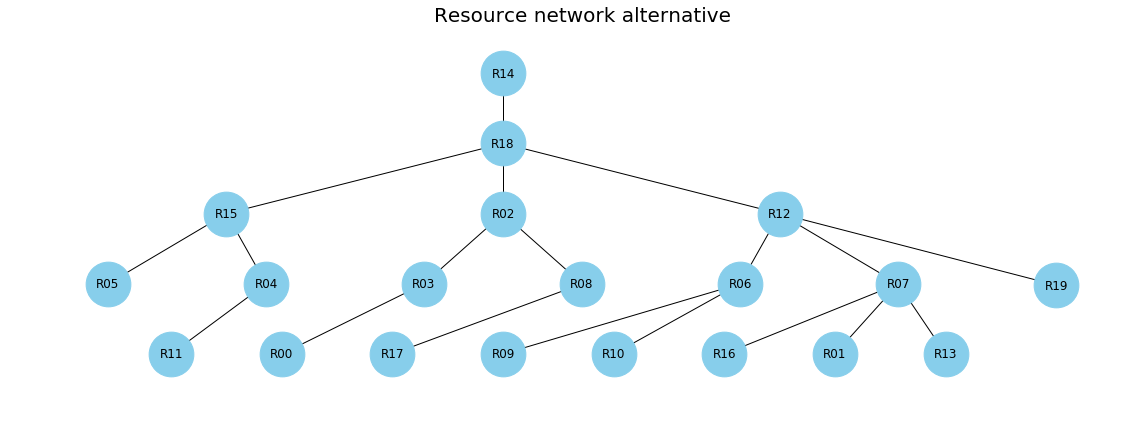

In [388]:
pos = tree_position(tempG)
pos.update({aa:(1.0, 0.33)})
plt.figure(figsize=(16, 6))
nx.draw_networkx(tempG, pos=pos, node_size=2000, node_color='skyblue')
plt.axis('off')
plt.title('Resource network alternative', fontsize=20)
#axes[1].set_title('Resource Network', fontsize=20)
plt.tight_layout()
plt.savefig('../../assets/images/markdown_img/180816_R_net_alt.png', dpi=200)
plt.show()

In [14]:
## activity 별로 일하는데 소요되는 시간을 쭉 뽑아서 time dist를 추정할 수 있지 않을까? 
## normal, exp, tri 중 무엇으로 할지는 봐야 할듯 
## each activity의 min, mode, max를 찾기 
activity_duration_dict = {k:[] for k in set(df['activity'])}
for g in df.groupby(['process', 'activity']):
    act_key = g[0][1]# g[0] ==> (process, activity)
    activity_duration_dict[act_key].append(g[1]['timestamp'].iloc()[1] - g[1]['timestamp'].iloc()[0])

In [15]:
def find_mode(input_lst):
    ma, mi = max(input_lst), min(input_lst)
    bin_size = np.round(1+3.322*np.log10(len(input_lst)))## 최적의 binsize를 찾는 계산법 
    r_lst = ((x-mi)/(ma-mi) for x in input_lst)
    r_lst = (x//(1/(bin_size))/(bin_size) for x in r_lst)
    r_dict = {} ## collection Counter를 쓸 수도 있지만, 없이 하는게 더 의존성을 줄이고 좋을 것 같았음
    for k in (x*(ma-mi)+mi for x in r_lst):
        r_dict[k] = r_dict[k]+1 if k in r_dict.keys() else 1
    return sorted(r_dict.items(), key=lambda x: x[1], reverse=True)[0][0]

for k, v in activity_duration_dict.items():
    print(k)
    print(min(v), max(v), find_mode(v))

A04
1.12942259947 4.82398258705 2.77144926062
A03
1.18973751711 4.75359030176 2.77367208807
A02
1.20890864026 4.8002428085 2.80505715948
A01
1.21510830468 4.61377118978 3.10325435196
A00
1.26629037241 4.80761577845 2.8402127751


In [ ]:
## networkx 를 이용해서 tree구조를 만들고 관리하기 

In [ ]:
nx.is_tree()

complete


In [197]:
"aaa".split()[0]

'aaa'